In [1]:
from preparation import import_data, get_dtypes, compute_correlation,categorical_variables_selection,encode,normalize,plot_all_histograms,cramers_v_table,impute_with_random_forest
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from scipy.stats import chi2_contingency
pd.set_option('display.max_columns', None)



In [2]:
input_path="../01_Input_Data/bank-additional-full.csv"
data=import_data(input_path)


In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Nous avons bien 20 colonnes en tout (étant donné que nous avons supprimé la colonne Duration comme demandé)

In [4]:
data.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


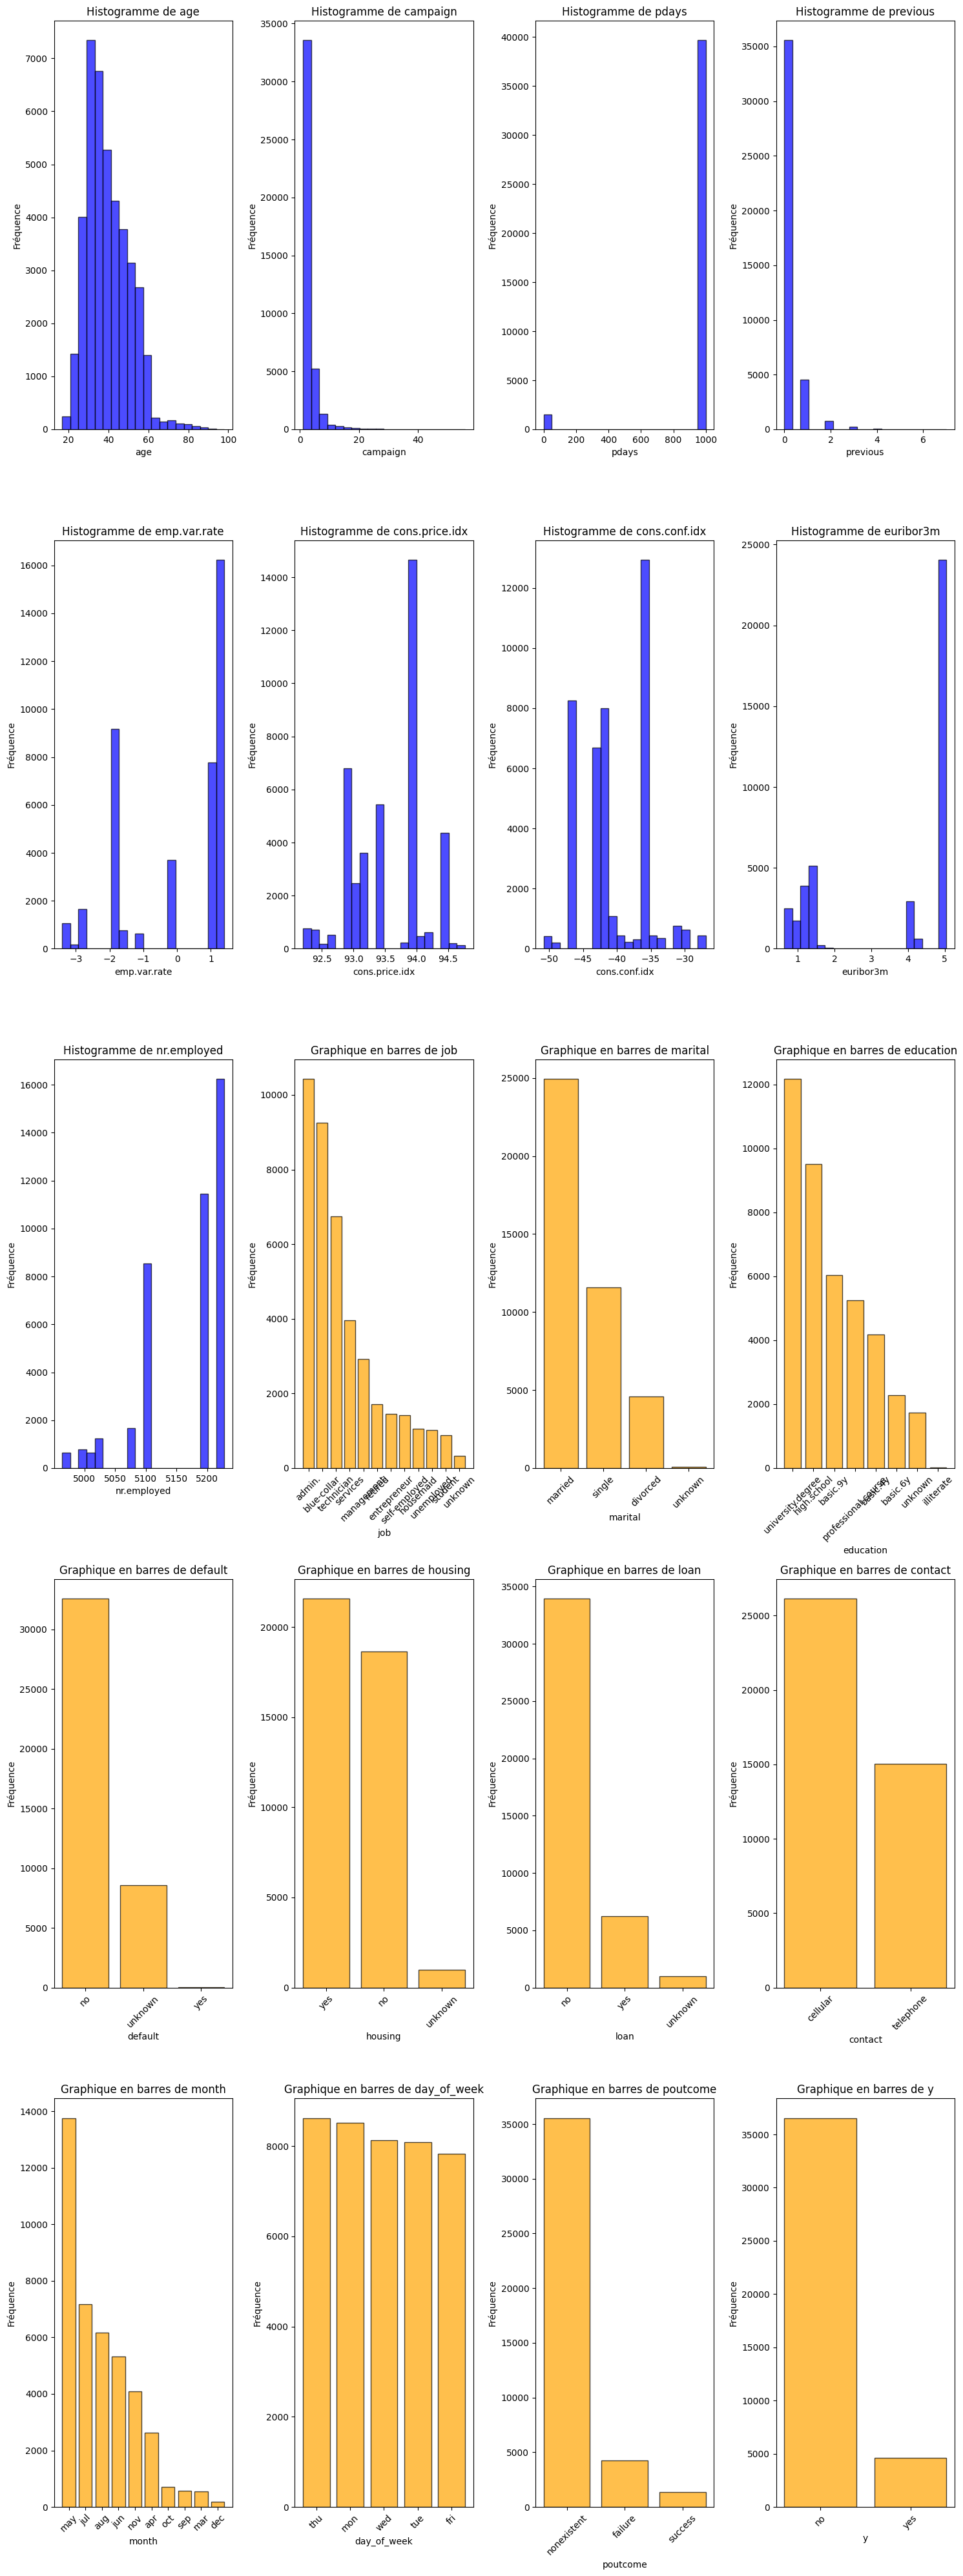

In [5]:
plot_all_histograms(data,bins=20)

In [6]:
dtype_to_column = get_dtypes(data)
dtype_to_column

{dtype('O'): ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'y'],
 dtype('float64'): ['emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed'],
 dtype('int64'): ['age', 'campaign', 'pdays', 'previous']}

On remarque beaucoup d'Uknown présents dans les données catégorielles (en jaune), on va chercher à les enlever dans la suite, soit en supprimant les individus les contenant, soit en utilisant un algorithme knn (on va devoir encoder les données avant).

On choisit ici d'enlever la colonne 'Default' car ne contient que 3 yes ainsi que beaucoup de données manquantes, elle ne nous apprend pas grand chose.

In [7]:

yes_default = data[data['default'] == 'yes']
yes_default

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
21580,48,technician,married,professional.course,yes,no,no,cellular,aug,tue,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
21581,48,technician,married,professional.course,yes,yes,no,cellular,aug,tue,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
24866,31,unemployed,married,high.school,yes,no,no,cellular,nov,tue,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no


In [8]:
data=data.drop(columns=['default'])


# Traitement des 'unknown'

Nous choisissons de supprimer les individus avec des unknown dans les colonnes à faible proportion de unknown (job,marital,housing et loan) et utiliser knn sur education

In [9]:

#Remplacement des 'unknown' par np.nan
data_copy = data.replace('unknown', np.nan)
#Suppression des individus avec les na dans les colonnes correspondantes
data_copy=data_copy.dropna(subset=[col for col in data_copy.columns if col != 'education'])

Encodage des données

In [10]:

data_copy_encoded=encode(data=data_copy,method="ordinal")

In [11]:
data_copy_encoded.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3.0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7.0,1.0,3.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7.0,1.0,3.0,1.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0.0,1.0,1.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7.0,1.0,3.0,0.0,1.0,1.0,6.0,1.0,1,999,0,1.0,1.1,93.994,-36.4,4.857,5191.0,0


RandomForest sur la colonne 'education'

In [12]:
data_copy_encoded=impute_with_random_forest(df=data_copy_encoded,target_column='education',param_grid={'n_estimators': [100],'max_depth': [10],'min_samples_split': [10] })

c:\Users\amine\OneDrive\Documents\Dauphine\ML\ml-python\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amine\OneDrive\Documents\Dauphine\ML\ml-python\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amine\OneDrive\Documents\Dauphine\ML\ml-python\.venv\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\

Meilleurs hyperparamètres trouvés : {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


c:\Users\amine\OneDrive\Documents\Dauphine\ML\ml-python\modèle Régression Logistique\data\preparation.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[missing_idx] = predicted_values


In [13]:
print(get_dtypes(data_copy_encoded))
print(get_dtypes(data))

{dtype('float64'): ['job', 'marital', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'education'], dtype('int64'): ['age', 'campaign', 'pdays', 'previous', 'y']}
{dtype('O'): ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'], dtype('float64'): ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], dtype('int64'): ['age', 'campaign', 'pdays', 'previous']}


# Variables numériques

On va calculer les corrélations et enlever les variables numériques qui sont corrélées à plus de 0.7 

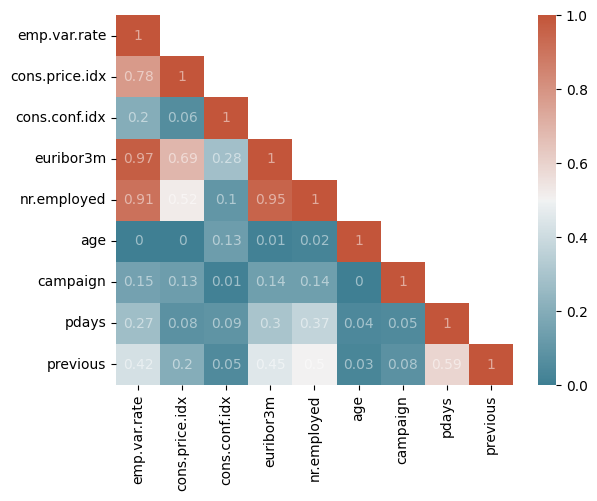

In [14]:
correlation = compute_correlation(data=data_copy)

In [15]:
data_copy=data_copy.drop(columns=['emp.var.rate'])
data_copy_encoded.drop(columns=['emp.var.rate'])

,age,job,marital,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education
0,56,3.0,1.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,93.994,-36.4,4.857,5191.0,0,0.0
1,57,7.0,1.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,93.994,-36.4,4.857,5191.0,0,3.0
2,37,7.0,1.0,1.0,0.0,1.0,6.0,1.0,1,999,0,1.0,93.994,-36.4,4.857,5191.0,0,3.0
3,40,0.0,1.0,0.0,0.0,1.0,6.0,1.0,1,999,0,1.0,93.994,-36.4,4.857,5191.0,0,1.0
4,56,7.0,1.0,0.0,1.0,1.0,6.0,1.0,1,999,0,1.0,93.994,-36.4,4.857,5191.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5.0,1.0,1.0,0.0,0.0,7.0,0.0,1,999,0,1.0,94.767,-50.8,1.028,4963.6,1,5.0
41184,46,1.0,1.0,0.0,0.0,0.0,7.0,0.0,1,999,0,1.0,94.767,-50.8,1.028,4963.6,0,5.0
41185,56,5.0,1.0,1.0,0.0,0.0,7.0,0.0,2,999,0,1.0,94.767,-50.8,1.028,4963.6,0,6.0
41186,44,9.0,1.0,0.0,0.0,0.0,7.0,0.0,1,999,0,1.0,94.767,-50.8,1.028,4963.6,1,5.0


,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age,campaign,pdays,previous
cons.price.idx,1.00,0.06,0.69,0.52,0.00,0.13,0.08,0.20
cons.conf.idx,0.06,1.00,0.28,0.10,0.13,0.01,0.09,0.05
euribor3m,0.69,0.28,1.00,0.95,0.01,0.14,0.30,0.45
nr.employed,0.52,0.10,0.95,1.00,0.02,0.14,0.37,0.50
age,0.00,0.13,0.01,0.02,1.00,0.00,0.04,0.03
campaign,0.13,0.01,0.14,0.14,0.00,1.00,0.05,0.08
pdays,0.08,0.09,0.30,0.37,0.04,0.05,1.00,0.59
previous,0.20,0.05,0.45,0.50,0.03,0.08,0.59,1.00


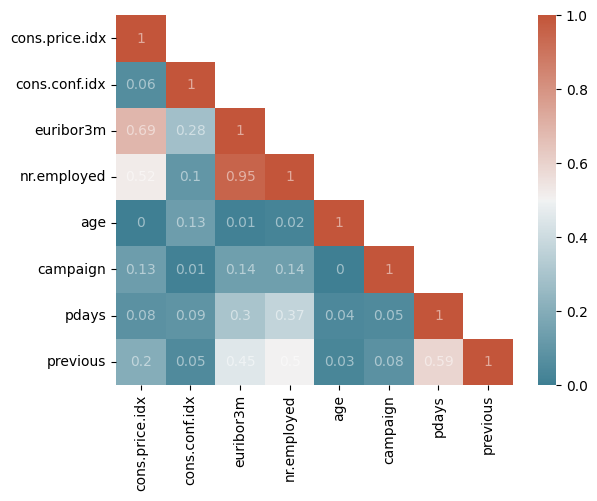

In [16]:
compute_correlation(data=data_copy)

# Variables catégorielles

,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,y
job,1.000000,0.222656,0.388587,0.023576,0.022934,0.125735,0.110999,0.021294,0.100274,0.152631
marital,0.222656,1.000000,0.146647,0.013934,0.005883,0.073597,0.062239,0.016909,0.035824,0.053317
education,0.388587,0.146647,1.000000,0.022852,0.013393,0.122441,0.103715,0.021805,0.042724,0.066674
housing,0.023576,0.013934,0.022852,1.000000,0.046174,0.081874,0.075470,0.022195,0.025319,0.011595
loan,0.022934,0.005883,0.013393,0.046174,1.000000,0.011928,0.021070,0.012518,0.000751,0.004060
contact,0.125735,0.073597,0.122441,0.081874,0.011928,1.000000,0.607863,0.055597,0.240160,0.143037
month,0.110999,0.062239,0.103715,0.075470,0.021070,0.607863,1.000000,0.068205,0.241438,0.273478
day_of_week,0.021294,0.016909,0.021805,0.022195,0.012518,0.055597,0.068205,1.000000,0.018159,0.024234
poutcome,0.100274,0.035824,0.042724,0.025319,0.000751,0.240160,0.241438,0.018159,1.000000,0.320797
y,0.152631,0.053317,0.066674,0.011595,0.004060,0.143037,0.273478,0.024234,0.320797,1.000000


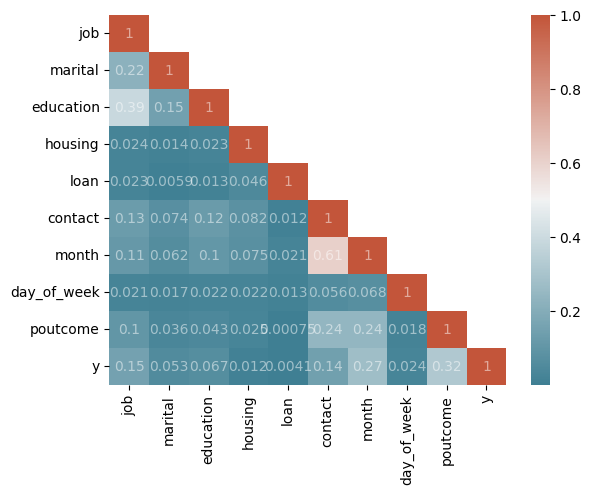

In [17]:
cramers_v_table(df=data_copy)

In [18]:
data_copy=categorical_variables_selection(data_copy,testcramerV_threshold=0.75)
data_copy_encoded=data_copy_encoded[data_copy.columns]

In [19]:
data_copy_encoded.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

# Normalisation des données

In [20]:
data_copy_encoded=normalize(data=data_copy_encoded,columns_to_scale=[col for col in data_copy_encoded.columns if data_copy_encoded[col].abs().max() > 1 ]) #On utilise un StandardScaler ici et on scale uniquement les colonnes dont la valeur max en valeur absolue est supétrieure à 1
data_copy_encoded.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.539987,-0.187112,-0.279922,-1.743941,0.0,0.0,1.0,0.762759,-0.71765,-0.566762,0.194855,-0.349299,0.193201,0.728011,0.890426,0.713981,0.33192,0
1,1.636117,0.939651,-0.279922,-0.295138,0.0,0.0,1.0,0.762759,-0.71765,-0.566762,0.194855,-0.349299,0.193201,0.728011,0.890426,0.713981,0.33192,0
2,-0.286490,0.939651,-0.279922,-0.295138,1.0,0.0,1.0,0.762759,-0.71765,-0.566762,0.194855,-0.349299,0.193201,0.728011,0.890426,0.713981,0.33192,0
3,0.001901,-1.032184,-0.279922,-1.261007,0.0,0.0,1.0,0.762759,-0.71765,-0.566762,0.194855,-0.349299,0.193201,0.728011,0.890426,0.713981,0.33192,0
4,1.539987,0.939651,-0.279922,-0.295138,0.0,1.0,1.0,0.762759,-0.71765,-0.566762,0.194855,-0.349299,0.193201,0.728011,0.890426,0.713981,0.33192,0
